# Import libraries and load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


base_path = "/content/drive/MyDrive/CIC-IDS/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/MachineLearningCSV/MachineLearningCVE"

csv_files = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

print("Loading CSVs...")
dfs = [pd.read_csv(os.path.join(base_path, f)) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)
df.columns = df.columns.str.strip()

print("Dataset shape:", df.shape)

Loading CSVs...
Dataset shape: (2830743, 79)


# Drop columns

In [3]:
drop_cols = [
    'Timestamp', 'Flow ID', 'Src IP', 'Dst IP',
    'Src Port', 'Dst Port', 'Protocol'
]

for col in drop_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# remove rows without a Label
df = df.dropna(subset=["Label"])

# Features and labels

In [4]:
X = df.drop(columns=["Label"])
X = X.select_dtypes(include=[np.number])  # keep only numeric
y = df["Label"]

print("Before fixing inf/nan:", X.shape, y.shape)

# fix infinity and NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = X.fillna(X.median(numeric_only=True))

print("After fixing inf/nan:", X.shape, y.shape)
print("Any inf left? ", np.isinf(X.to_numpy()).any())
print("Any NaN left? ", np.isnan(X.to_numpy()).any())

Before fixing inf/nan: (2830743, 78) (2830743,)
After fixing inf/nan: (2830743, 78) (2830743,)
Any inf left?  False
Any NaN left?  False


# Encode labels

In [5]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

print("Number of classes:", num_classes)
print("Class mapping:")
for i, cls in enumerate(le.classes_):
    print(f"  {i}: {cls}")

Number of classes: 15
Class mapping:
  0: BENIGN
  1: Bot
  2: DDoS
  3: DoS GoldenEye
  4: DoS Hulk
  5: DoS Slowhttptest
  6: DoS slowloris
  7: FTP-Patator
  8: Heartbleed
  9: Infiltration
  10: PortScan
  11: SSH-Patator
  12: Web Attack � Brute Force
  13: Web Attack � Sql Injection
  14: Web Attack � XSS


# Train/test split and scaling

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# one-hot encode labels for multi-class softmax
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Train shape: (2264594, 78)  Test shape: (566149, 78)


# Defining BPNN

In [7]:
input_dim = X_train_scaled.shape[1]
print("Input dimension (features):", input_dim)

from tensorflow.keras.layers import Input # Added for missing Input layer
model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Input dimension (features): 78


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,343 (75.56 KB)

 Trainable params: 19,343 (75.56 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [8]:
history = model.fit(
    X_train_scaled,
    y_train_cat,
    epochs=30,           # adjusted
    batch_size=1024,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9119 - loss: 0.3273 - val_accuracy: 0.9694 - val_loss: 0.0730
Epoch 2/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9687 - loss: 0.0793 - val_accuracy: 0.9746 - val_loss: 0.0550
Epoch 3/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9736 - loss: 0.0650 - val_accuracy: 0.9789 - val_loss: 0.0490
Epoch 4/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9765 - loss: 0.0576 - val_accuracy: 0.9800 - val_loss: 0.0468
Epoch 5/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9776 - loss: 0.0546 - val_accuracy: 0.9809 - val_loss: 0.0447
Epoch 6/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9786 - loss: 0.0524 - val_accuracy: 0.9826 - val_loss: 0.0434
Epoch 7/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9792 - loss: 0.0510 - val_accuracy: 0.9824 - val_loss: 0.0420
Epoch 8/30
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9799 - los

# Evaluation

In [11]:
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Predicted class indices
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification report (multi-class):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

overall_acc = accuracy_score(y_test, y_pred)
print(f"Overall accuracy (from sklearn): {overall_acc:.4f}")


Evaluating on test set...
Test loss: 0.0229
Test accuracy: 0.9934

Classification report (multi-class):
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      1.00    454620
                       Bot       0.96      0.36      0.52       393
                      DDoS       1.00      0.99      1.00     25606
             DoS GoldenEye       0.99      0.97      0.98      2059
                  DoS Hulk       0.96      0.99      0.98     46215
          DoS Slowhttptest       0.88      0.98      0.93      1100
             DoS slowloris       0.97      0.98      0.98      1159
               FTP-Patator       0.99      0.99      0.99      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.29      0.44         7
                  PortScan       0.99      1.00      0.99     31786
               SSH-Patator       0.96      0.96      0.96      1179
  Web Atta

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


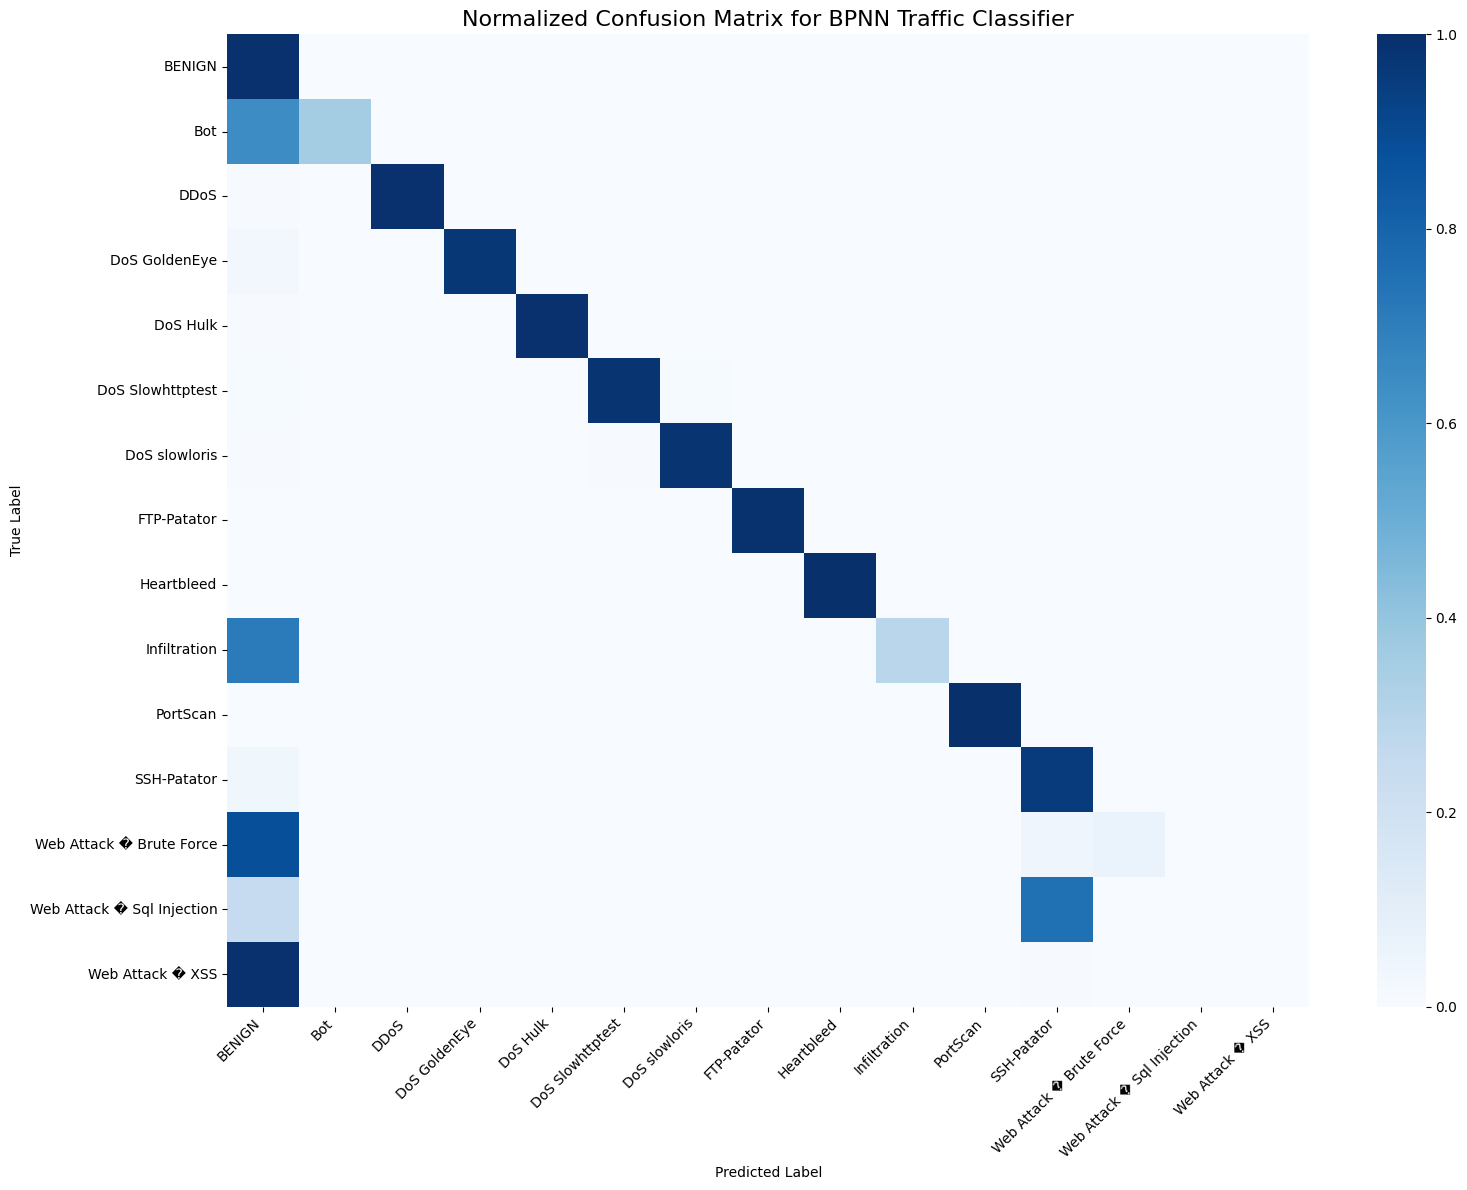

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize if you want percentages (optional)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Class labels from your label encoder
labels = le.classes_

plt.figure(figsize=(16, 12))
sns.heatmap(cm_norm,
            annot=False,   # change to True if you want numbers inside
            cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.title("Normalized Confusion Matrix for BPNN Traffic Classifier", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

print("\n=== Random Forest Baseline (Multi-class) ===")

# You can tune these later if needed
rf_clf = RandomForestClassifier(
    n_estimators=100,        # number of trees
    max_depth=None,         # let trees grow until pure / min_samples
    n_jobs=-1,              # use all cores
    class_weight="balanced",# help with class imbalance
    random_state=42
)

start_time = time.time()
rf_clf.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"[INFO] Training time: {train_time:.2f} seconds")

# Evaluation
start_time = time.time()
y_pred_rf = rf_clf.predict(X_test_scaled)
infer_time = time.time() - start_time
print(f"[INFO] Inference time on test set: {infer_time:.2f} seconds")

rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest test accuracy: {rf_acc:.4f}")

print("\nRandom Forest classification report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

print("Random Forest confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))



=== Random Forest Baseline (Multi-class) ===
[INFO] Training time: 1339.27 seconds
[INFO] Inference time on test set: 7.24 seconds

Random Forest test accuracy: 0.9987

Random Forest classification report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    454620
                       Bot       0.87      0.79      0.83       393
                      DDoS       1.00      1.00      1.00     25606
             DoS GoldenEye       1.00      0.99      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     46215
          DoS Slowhttptest       0.99      0.99      0.99      1100
             DoS slowloris       0.99      0.99      0.99      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.86      0.92         7
                  PortScan       0.99      1

In [13]:
from sklearn.metrics import f1_score

rf_f1_macro = f1_score(y_test, y_pred_rf, average="macro")
rf_f1_weighted = f1_score(y_test, y_pred_rf, average="weighted")

print(f"Random Forest F1-macro   : {rf_f1_macro:.4f}")
print(f"Random Forest F1-weighted: {rf_f1_weighted:.4f}")


Random Forest F1-macro   : 0.8825
Random Forest F1-weighted: 0.9986
